# Day 2 ATIS-2025 Workshop

## Part A — Quantum Teleportation


### Import Libraries

In [2]:
!pip install qiskit
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

Fidelity of teleported state: 0.9814453125


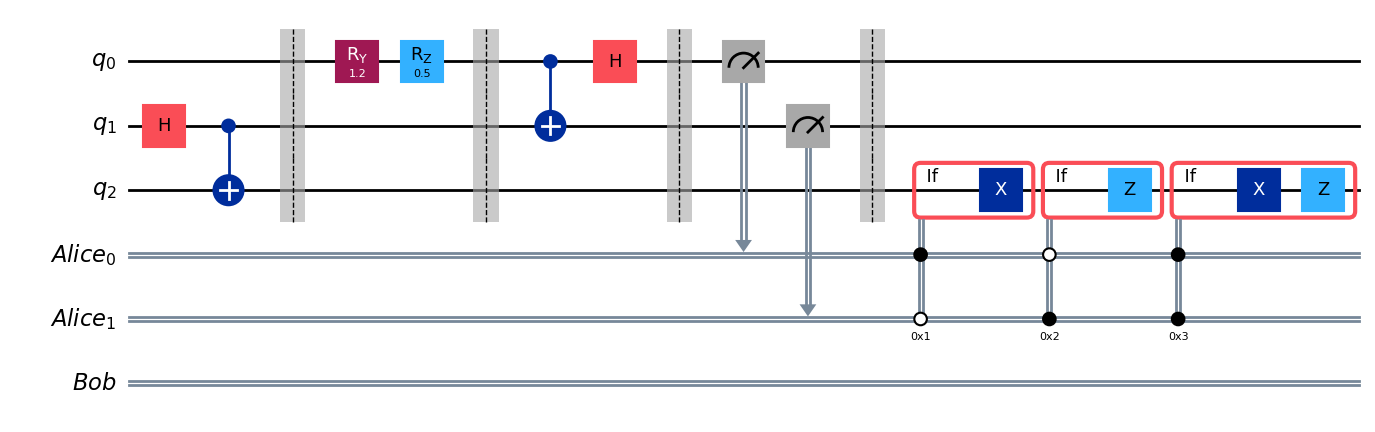

In [ ]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit import Clbit
from typing import cast

qreg = QuantumRegister(3, 'q')
alice = ClassicalRegister(2, 'Alice')
bob = ClassicalRegister(1, 'Bob')
qc1 = QuantumCircuit(qreg, alice, bob)

qc1.h(qreg[1])          # create entanglement between alice and bob
qc1.cx(qreg[1], qreg[2])
qc1.barrier()

qc1.ry(1.2, qreg[0])  # create arbitrary state to be teleported
qc1.rz(0.5, qreg[0])
qc1.barrier()

qc1.cx(qreg[0], qreg[1])    # bell measurement
qc1.h(qreg[0])
qc1.barrier()

qc1.measure(qreg[0], alice[0])  # alice[0]
qc1.measure(qreg[1], alice[1])  # alice[1]
qc1.barrier()

# if alice measures 00, do nothing
with qc1.if_test((alice, 1)):  # if alice measures 01, apply X
    qc1.x(qreg[2])
with qc1.if_test((alice, 2)):  # if alice measures 10, apply Z
    qc1.z(qreg[2])      
with qc1.if_test((alice, 3)):  # if alice measures 11, apply X and Z
    qc1.x(qreg[2])
    qc1.z(qreg[2])



simulator = AerSimulator()
compiled_circuit = transpile(qc1, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts(compiled_circuit)

num_alice_bits = len(alice)
alice_counts = {}
for k, v in counts.items():
    bits = ''.join(k.split())            # remove spaces -> e.g. '011'
    alice_bits = bits[-num_alice_bits:]  # take last bits corresponding to Alice -> e.g. '11'
    alice_counts[alice_bits] = alice_counts.get(alice_bits, 0) + v

ideal_counts = {'00': 256, '01': 256, '10': 256, '11': 256}
shots = sum(counts.values())
fidelity = sum(min(alice_counts.get(key, 0), ideal_counts[key]) for key in ideal_counts) / shots

print("Fidelity of teleported state:", fidelity)

qc1.draw('mpl', cregbundle=False)

